## Find non periodic system when sweeping parameter

In [5]:
# use phase space tranjectory first
# use ly second (maybe)
import model_num as mn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
import generate_video
import copy
import multiprocessing as mp
import time
from tqdm import tqdm
%matplotlib inline
plt.rcParams["animation.html"] = "html5" #Use HTML to render with 'inline' backend


In [6]:
x0 = mn.get_good_default_initial_values()
dt = 5e-1
steps = 5e4
param_file='./model_values_edited.json'
params = mn.load_param_file(param_file)
hist = mn.calculate_data(x0, steps, dt, params)

100%|██████████| 50000/50000 [00:01<00:00, 40451.19it/s]


In [7]:
# y = (hist[100:5000,0] + 4.25) # (49900,)
# plt.figure()
# plt.plot(y)

# yf = np.abs(fft(y))
# xf = fftfreq(len(y))
# plt.figure()
# plt.plot(xf, yf)
# am = np.argmax(yf)
# print(am)
# print(xf[am])

# y = np.sin(0.01 * np.linspace(0, 5000, 50000)) # (49900,)
# plt.figure()
# plt.plot(y)

# yf = np.abs(fft(y))
# xf = fftfreq(len(y))
# plt.figure()
# plt.plot(xf, yf)
# am = np.argmax(yf)
# print(am)
# print(xf[am])

def is_periodic(data:np.ndarray)->bool:
    assert len(data.shape) == 1, "data must be 1-d, got shape" + repr(data.shape)
    yf = np.abs(fft(data))
    xf = fftfreq(data.size)
    am = np.argmax(yf)
    # print(am)
    # print(f"Freqency is {xf[am]}, and derived wavelength is {data.size * xf[am]}")
    return (xf[am] >= 1/data.size + 1e-5)

def get_wavelength(data:np.ndarray)->float:
    assert len(data.shape) == 1, "data must be 1-d, got shape" + repr(data.shape)
    yf = np.abs(fft(data))
    xf = fftfreq(data.size)
    am = np.argmax(yf)
    # print(am)
    # print(f"Freqency is {xf[am]}, and derived wavelength is {data.size * xf[am]}")
    return data.size * xf[am]

print(f"Is data periodic? {is_periodic(hist[100:,0] - np.mean(hist[100:,0]))}")

Is data periodic? False


100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


Elapsed time: 35.073216915130615


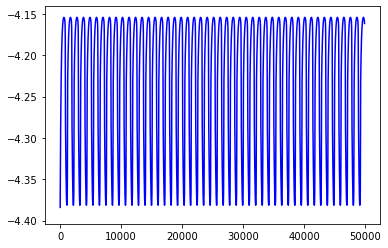

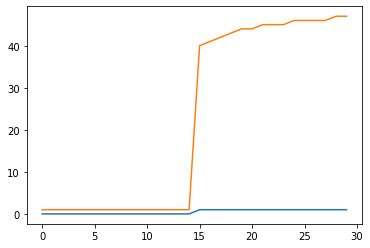

In [15]:
window = 0.4 # what multiple of the default value we want to scan around
search_points = 30
frames = []

def get_perodic_array(window:float, search_points:int):
    is_periodic_arr = []
    wavelength_arr = []
    # using only the first hyperparameter
    default = params[8]
    window_breadth = default * window

    start_time = time.time()
    for h in tqdm(np.linspace(default - window_breadth, default + window_breadth, search_points)):
        # print(f"using hyperparameter \'{h}\'")
        new_parameters = copy.copy(params)
        new_parameters[8] = h
        hist = mn.calculate_data(x0, steps, dt, new_parameters, method='RK2', progress_bar=False)
        # plt.plot(hist[100:,0])
        # plt.show()
        frames.append(plt.plot(hist[100:,0], color='b'))
        normalized_trimmed_hist = (hist[100:,0] - np.mean(hist[100:,0]))
        is_periodic_arr.append(is_periodic(normalized_trimmed_hist))
        wavelength_arr.append(get_wavelength(normalized_trimmed_hist))
        
    print(f"Elapsed time: {time.time() - start_time}")
    return is_periodic_arr, wavelength_arr

is_periodic_arr, wavelength_arr = get_perodic_array(window, search_points)
ani = generate_video.generate_video2(frames, interval=150, repeat_delay=1000)
plt.figure()
plt.plot(np.array(is_periodic_arr, dtype=np.int32))
plt.plot(np.array(wavelength_arr, dtype=np.float32))
ani

# Perform experiment~!